# Course Project – IME692, Fall 2021

## Question

#### Develop  a  predictive  model  in  which  the  dependent variable  isCvdVax_DisparityY.  Your  task  is  to examine  the  role  of  different  socioeconomic and  demographic  variables  indetermining  thecovid-19 vaccination rate disparities. Note following points to complete this project.

(1)You  are  free  to  choose  any prediction/regression model  to  examine  the  role  of  predictors  in determining CvdVax_DisparityY.  But  use  only  data labelledas “train” for the model building purpose. Evaluate the performance ofyourmodels on the test data.

(2)Report three models that give best result on the test dataset. Mentionthe final model that you would select. Explainthe reason for its selection. 

(3)How would you assess the importance of different predictors in your model? Which predictors are most important in determining the racial disparity in covid-19 vaccinate rate? 

(4)Areyour  findings  similar  to  the resultsreported  by  authors  in  Table  1of  the  article  (see  the hyperlink above)? If not, why? 

(5)Upload Python/R code with your project report. 

# programme structure and points

### Note: this is just a point-wise summary of project findings. A detailed version of each point is given with their respective parts, and a compact version of that is in the report.

- first we import all the required modules for various sections of project
- In pre-processing the data we have done:
    - simple train-test split based on `Test` feature in original dataset
    - basic z-score normalization of feature matrix
    - now to see if we can discard some less important(meaning features that does not explain much variability in data)
        - we see that it is not possible 
        - as about 12-13 features explain around 95% variance
        - so removing 2-3 features does not help much
- Next we defined some functions that we use throughout the project
    - `coefplot` helps us plotting the coefficients we get from various models, after training
    - `model`: this one prints model test-trian summary in nice formate and also uses(internally) `coefplot` to plot coef from models
- Now we use these functions for various models that we experiment with, in particular
    **`Note:`** Corresponding theoris are given in the report for these models
    - Linear models:(Out of these we choose best model)
        - Normal Linear Regression
        - Lasso Regression(L1 regularizer)
        - Ridge Regression(L2 regularizer)
        - Elastinet Regression(L1 and L2 regularizer mixed)
    - Random Forest
    - Support Vector Regression(SVR)
        - With different values of hyper-parameter `C` and different kernels(linear,plot,rbf)
- Our findings about models:
    - We find that `Normal Linear regression` (with no restriction on coefficients) performs better than other linear models in terms of train mse(indicator of overfitting) and test mse(indicator of prediction performance on unseen data)
    - When Normal Linear regression is compared with Random forest and SVR, we find:
        - Although Random forest and SVR(with C=10 and kernel=rbf) gives lower test mse(although the improvment is quite small, relatively), but they the basic problem of overfitting the train data
        - they are not generalizing as well as Lasso does
        - Basically due to overfitting nature of Random Forest and SVR on our train data they are not being choosen as our best model
        - though they have slightly lower test mse; but the trade-off for this is not that good when looked overall since they overfit 
- So when compared we choose **`Normal Linear regressionn`**
- Now, with `Normal Linear regression` as our best model we work on feature importance:
    - please see last observations for this point, to avoid repeat we are not writing that here.


# libraries required

In [114]:
# basic modules
import numpy as np
import pandas as pd

# plot modules
import matplotlib.pyplot as plt
import seaborn as sns

# analysis modules
## pre-process and metrics
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

## linear analysis
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.linear_model import Ridge,RidgeCV
from sklearn.linear_model import Lasso,LassoCV
import statsmodels.api as sm

## random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

## svm analysis
from sklearn.svm import SVR



# pre-process

### split test-train

- separate independant and dependant variables
- dropped state and county columns 
    - since all variables are numeric except State and County Name

In [115]:
data=pd.read_csv('ime692_project.csv')

# avoid State and County name
cols=data.columns[2:].to_list()
data=data[cols]

# seperate data into test and train based on `Test` indicator
pd.options.mode.chained_assignment = None  # default='warn' --> to supress chain assignment warning <--
test_data=data.loc[data.Test==1] ## previous indices could be useful ##
train_data=data.loc[data.Test==0]

# assert split
print("==========================================")
print("No of testing observations: ",test_data.shape[0])
print("No of training observations: ",train_data.shape[0])
print("==========================================")

# drop the indicator inplace
test_data.drop('Test',axis=1,inplace=True)
train_data.drop('Test',axis=1,inplace=True)

# sepearate predicted and regressor variables
y_test_data=test_data['CvdVax_DisparityY'].tolist()
X_test_data=test_data.drop('CvdVax_DisparityY',axis=1)
y_train_data=train_data['CvdVax_DisparityY'].tolist()
X_train_data=train_data.drop('CvdVax_DisparityY',axis=1)

No of testing observations:  225
No of training observations:  531


### normalization

- z-score normalization is being done on features
    - can work with min-max also
- no need to normalize dependent variable

In [116]:
scalerInst=StandardScaler()
X_train_data_normalized=scalerInst.fit_transform(X_train_data)
X_test_data_normalized=scalerInst.fit_transform(X_test_data)

### Which variables to use(PCA)

- to check which features to use for further analysis
- if small no of features can explain significant variance then work with them only to avoid model becoming complex
    - if not then can not avoid features

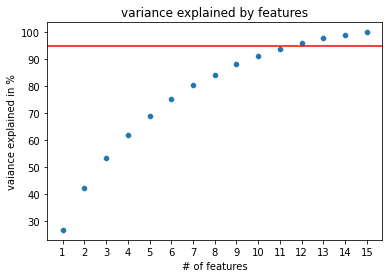

In [117]:
n=X_train_data_normalized.shape[1]
pca=PCA(n_components=n)
X_train_data_transformed=pca.fit_transform(X_train_data_normalized)
X_test_data_transformed=pca.fit_transform(X_test_data_normalized)

foo_ratio=pca.explained_variance_ratio_

# to get cummulative
var_ratio=[]
for i in range(n):
    var_ratio.append(100*sum(foo_ratio[0:i+1]))

# plotting the variance explined curve (in %)
ax=sns.scatterplot(x=np.arange(n)+1,y=var_ratio)
ax.axhline(95,color='red')
plt.title('variance explained by features')
plt.xlabel('# of features')
plt.ylabel('vaiance explained in %')
plt.xticks(np.arange(n)+1)
plt.show() # to avoid text outputs
# plt.savefig('pca.png')


**observations**

- PCA is not a good techniqe for this problem 
    - as no small number set of features explain variance quite significantly
    - if around 5-6 features would have explained around 90-95% variance then PCA would have been helpful, but that is not the case here

# functions for analysis

- function `model` uses test and train data with global scope
- these functions have been used throught the project

### function to plot coef plots for models

**`function parameters:`**
- coefDf: coef data frame with column names from project data
- name: [used as an identifier] name to be printed in plots

In [118]:
def coefplot(coefDf,name):
    # to tweak default barh visual
    kwargs={
    'alpha':0.8,
    'edgecolor':'#333',
    'facecolor':'#eef',
    'width':0.2
    }
    # to plot barh
    (coefDf['Weight of Coeff'].sort_values(ascending = False,kind='mergesort')).plot.barh(figsize=(8,8),**kwargs)
    plt.title(f'Importance of Coeff- {name}')
    plt.xlabel("Importance")
    plt.ylabel('Features')
    plt.show()

### general function for models

**`function parameters:`**
- plot: `Bool`
    - by default is set to `False`, to plot feature coeffs set it to `True`float
- c: `float`
    - tuning hyperparameter used for SVR model, default to 0.1
- kernel: ['linear', 'poly', 'rbf', 'sigmoid']
    - kernel used for SVR model, default to `linear`
- model_title: [used as an identifier]name to be printed in plots etc
- modelName: model `class` name imported from `sklearn`

In [119]:
def model(modelName,model_title,kernel='linear',c=0.1,plot=False,printText=False):
    if modelName==SVR:
        rm=modelName(kernel=kernel,C=c)
    else:
        rm=modelName()
    
    rm.fit(X_train_data_normalized,y_train_data)

    # test mse
    preds_test=rm.predict(X_test_data_normalized)
    MSE_test=mean_squared_error(y_test_data,preds_test)

    # train mse
    preds_train=rm.predict(X_train_data_normalized)
    MSE_train=mean_squared_error(y_train_data,preds_train)

    if printText==True:
        print(model_title)
        print(''.center(30,'='))
        print('Train MSE =',round(MSE_train,2))
        print('Test MSE =',round(MSE_test,2))
        print(''.center(30,'='))

    if plot==True:
        print('Relative Feature Importance Plot')
        kwargs={
            'alpha':0.8,
            'edgecolor':'#333',
            'facecolor':'#eef',
            'width':0.2
            }
        # to plot barh
        if modelName==RandomForestRegressor:
            coefDf = pd.DataFrame(rm.feature_importances_.T, columns=['Weight of Coeff'], index=X_train_data.columns)
        else:
            coefDf = pd.DataFrame(rm.coef_.T, columns=['Weight of Coeff'], index=X_train_data.columns)
        (coefDf['Weight of Coeff'].sort_values(ascending = False,kind='mergesort')).plot.barh(figsize=(8,8),**kwargs)
        plt.title(f'Importance of Coeff- {model_title}')
        plt.xlabel("Importance")
        plt.ylabel('Features')
        plt.show()

    return {'Model Name':model_title ,'Train':MSE_train,'Test':MSE_test}

In [120]:
# intialize lists to compare models
model_compare=[]
linear_models_compare=[]
# general plotting and printting settings can be changed here
# or one can override these settings in particular function calls
want_to_plot=True
want_to_print=True

# linear model

### normal multiple linear regression

Normal Linear Regression
Train MSE = 56.27
Test MSE = 68.35
Relative Feature Importance Plot


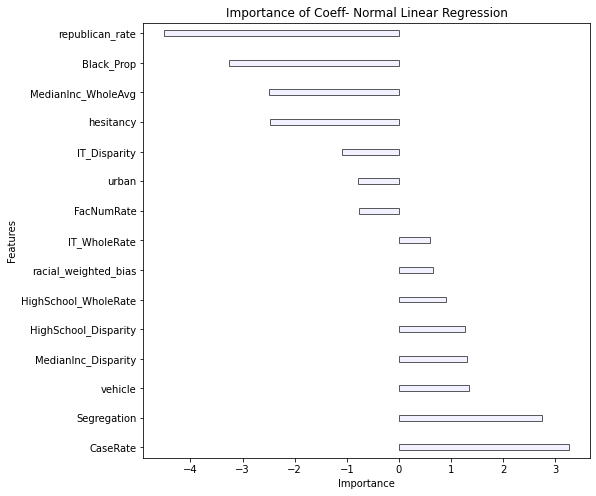

In [121]:
lm=model(LinearRegression,'Normal Linear Regression',plot=want_to_plot,printText=want_to_print)
model_compare.append(lm)
linear_models_compare.append(lm)

### restricted regression models

- here restricted models are, specifically: 
    - lasso(l1 norm)
    - ridge(l2 norm)
    - elastinet(l1 and l2 norm)
- we have seen linear model without any restrictions; now to try out this with restrictions we have included these models
- we will compare these models with normal linear model in two cases:
    - first case: with default alpha
    - second case: with best alpha in search space [to see if there is any improvement]

#### model names and titles

In [122]:
models=[
    {
        'title':'Lasso Regression Model',
        'name':Lasso,
        'cv':LassoCV
    },
    {
        'title':'Ridge Regression Model',
        'name':Ridge,
        'cv':RidgeCV
    },
    {
        'title':'Elastinet Regression Model',
        'name':ElasticNet,
        'cv':ElasticNetCV
    }
]

#### func used to cover restrictions linear regression models

**`function params`**

- cvFolds: no of folds to be used to choose best alpha in search space
- title, modelName, modelCV: self-explanatory

In [123]:
# func used to cover with restrictions linear regression models
def restrictModels(title,modelName,modelCV,cvFolds=10,plot=False,printText=False):
    # choosing alpha hyperparameter
    ## create search space
    r=np.linspace(-2,5,100)
    alphas=np.power(10*np.ones(100),r)
    ## get best possible alpha in search space
    rcv=modelCV(alphas=alphas,cv=cvFolds)
    rcv.fit(X_train_data_normalized,y_train_data)
    cvAlpha=rcv.alpha_

    # fit model
    rlm=modelName(alpha=cvAlpha)
    rlm.fit(X_train_data_normalized,y_train_data)

    # test mse
    preds_test=rlm.predict(X_test_data_normalized)
    MSE_test=mean_squared_error(y_test_data,preds_test)

    # train mse
    preds_train=rlm.predict(X_train_data_normalized)
    MSE_train=mean_squared_error(y_train_data,preds_train)

    if printText:
        # some nice formatting
        print(title)
        print(''.center(30,'='))
        print(f'CV alpha =',round(cvAlpha,2))
        print(f'Train MSE =',round(MSE_train,2))
        print(f'Test MSE =',round(MSE_test,2))
        print(''.center(30,'='))

    if plot:
        # plot
        coefDf = pd.DataFrame(rlm.coef_.T, columns=['Weight of Coeff'], index=X_train_data.columns)
        coefplot(coefDf,title)

    # return data dict
    return {'Model Name':title,'Train':MSE_train,'Test':MSE_test}

#### implementation for comparision[first case]

Lasso Regression Model(first-case)
Train MSE = 67.98
Test MSE = 75.7
Relative Feature Importance Plot


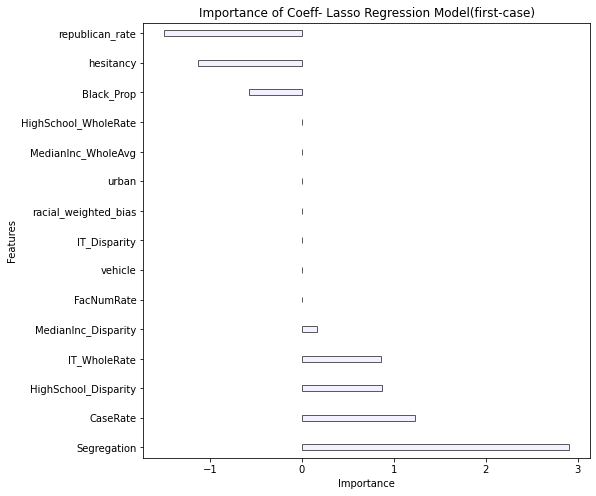

Ridge Regression Model(first-case)
Train MSE = 56.27
Test MSE = 68.37
Relative Feature Importance Plot


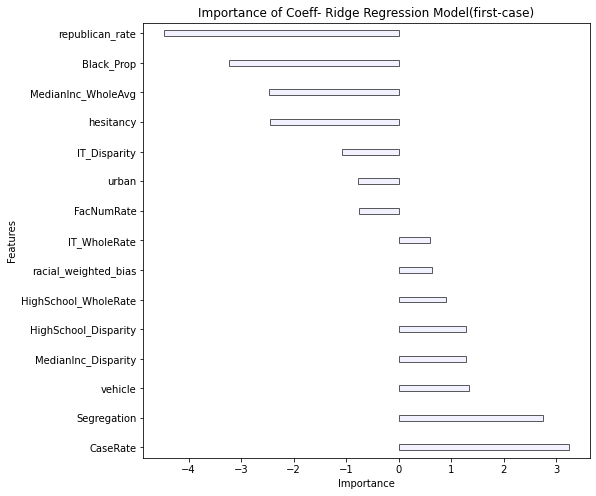

Elastinet Regression Model(first-case)
Train MSE = 68.39
Test MSE = 77.61
Relative Feature Importance Plot


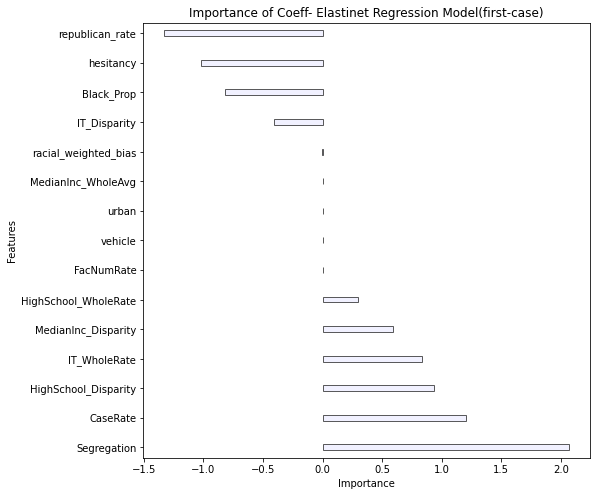

In [124]:
for m in models:
    linear_models_compare.append(model(m['name'],m['title']+'(first-case)',plot=want_to_plot,printText=want_to_print))

restrictedDf=pd.DataFrame(linear_models_compare)

#### observations:

- As expected models that use L1 regularizer does make some features sparse(meaning their coef are almost zero)
    - here elastinet and lasso does make some features sparse
- But that is when we have alpha to be `1`(default)
- When we optimize(see below section -- second case) over alpha we see that all these models give same result as Normal Linear Regression

#### implementation for comparision[second case]

Lasso Regression Model(second-case)
CV alpha = 0.01
Train MSE = 56.27
Test MSE = 68.31


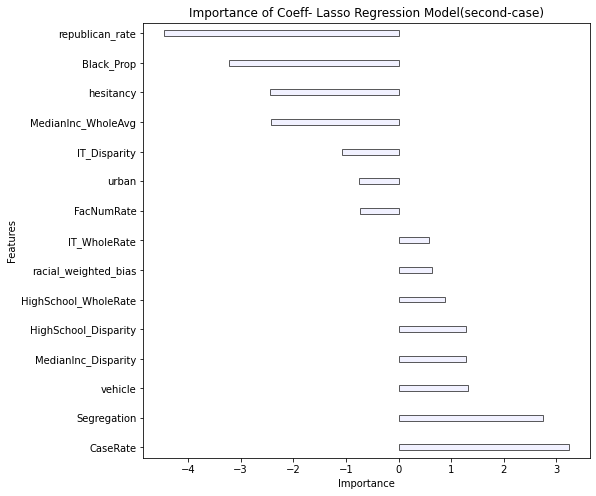

Ridge Regression Model(second-case)
CV alpha = 47.51
Train MSE = 57.23
Test MSE = 69.7


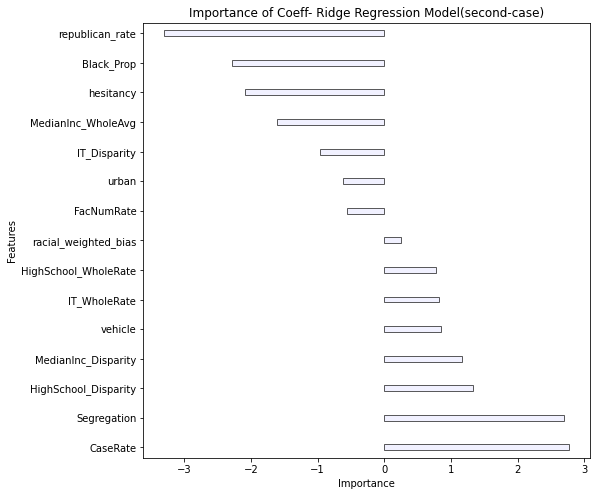

Elastinet Regression Model(second-case)
CV alpha = 0.04
Train MSE = 56.39
Test MSE = 68.53


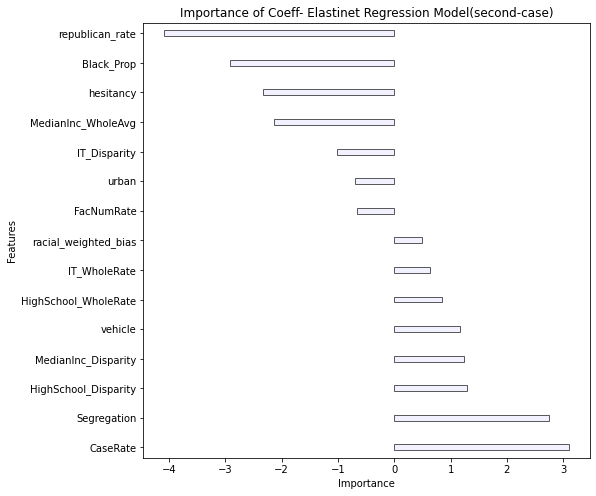

In [125]:
for m in models:
    linear_models_compare.append(restrictModels(m['title']+'(second-case)',m['name'],m['cv'],plot=want_to_plot,printText=want_to_print))

restrictedDf=pd.DataFrame(linear_models_compare)

#### observations for second-case

- when we optimize we see that models does better on test dataset(meaning test mse drops) and their alpha values are also around zero -- that means they are becoming normal linear models when optimized and give same test and train MSE as normal linear regression model does
- It implies that the restrictions we put in these models are not good for model when model is optimized. So when we work with default alpha(=1) they penelize some features coefficients and in turn this leads to worse (both train and test) mse than normal linear regression. And when using grid search, we optimize we can observe that they are optimized for almost zero value of alpha that means they are simply our basic normal linear regression model. It is also proved by their test and train mse as they come exactly close to the normal linear regression test and train mse values
- All these numerical values for train and test mse are given below
- see below observation for why we choose `Normal linear regression`

#### Observations

- from below dataframe, it is clear that Lasso(second-case) does slightly better than the Normal linear model
- Lasso (second-case) has no more overfitting problem than normal linear model does
- We choose Normal Linear Regression over these restricted models, reasons are,
    - model simplicity
    - as we have seen after alpha optimization our restricted models comes back to normal linear regression model, so to keep things simple we choose `Normal Linear Regression`
    - model findings are more interpretability
    - Normal does better or equal to other model on test dataset
    - Normal does not overfit more than any other restricted models ; meaning they all overfit train data similarly
- keeping these things in mind we choose **`NORMAL LINEAR REGRESSION MODEL`** out of linear models

In [126]:
print(''.center(60,'='))
print(restrictedDf)
print(''.center(60,'='))
print('The best model based on simplicity and train-test MSE is >>> NORMAL LINEAR REGRESSION MODE')
print(''.center(60,'='))

                                Model Name      Train       Test
0                 Normal Linear Regression  56.266316  68.353944
1       Lasso Regression Model(first-case)  67.983229  75.702897
2       Ridge Regression Model(first-case)  56.267138  68.370663
3   Elastinet Regression Model(first-case)  68.387424  77.608423
4      Lasso Regression Model(second-case)  56.270005  68.312572
5      Ridge Regression Model(second-case)  57.232917  69.700699
6  Elastinet Regression Model(second-case)  56.392747  68.530688
The best model based on simplicity and train-test MSE is >>> NORMAL LINEAR REGRESSION MODE


# Random Forest

- to do the heavy lifting `model`(defined above) function have been used

Random Forest
Train MSE = 8.05
Test MSE = 64.0
Relative Feature Importance Plot


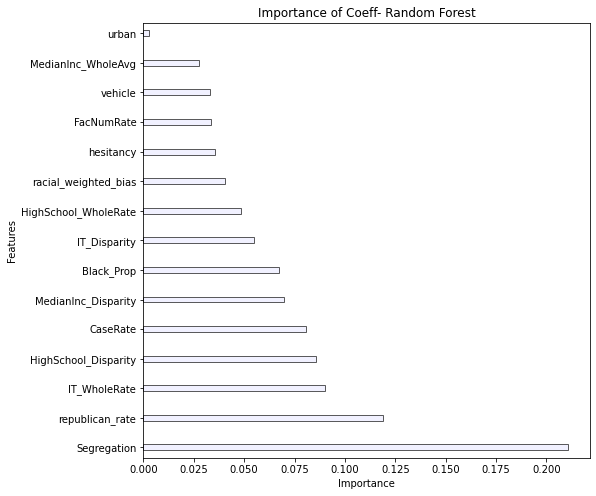

In [127]:
rf=model(RandomForestRegressor,'Random Forest',plot=want_to_plot,printText=want_to_print)
model_compare.append(rf)

# Support Vector Resgression

- to do the heavy lifting `model`(defined above) function have been used

Support Vector Resgression
Train MSE = 61.93
Test MSE = 72.55
Relative Feature Importance Plot


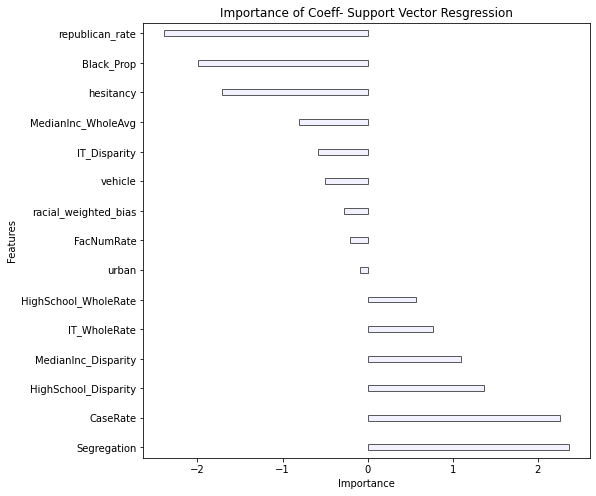

In [128]:
svr=model(SVR,'Support Vector Resgression',plot=want_to_plot,printText=want_to_print)
model_compare.append(svr)

### tuning hyperparameter(C) in SVR

- till now we have random forest test mse(although it overfits , we will see below) to be lowest but it is overfitting the data as its train mse is much lowwer than test mse.
- to see if SVR outperforms random after tuning `C`(in terms of test mse), we do:
    - work with bunch of different values of `C` and see if any one does better than Random Forest(in terms of test mse)

In [129]:
# optimizing the parameter C in SVC
C=[0.01,0.1,1,10,100]
kernels=['linear', 'poly', 'rbf']
compare_svr=[]
for c in C:
    for k in kernels:
        compare_svr.append(model(SVR,f'SVR (C={c},kernel={k})',kernel=k,c=c))

In [130]:
pd.DataFrame(compare_svr)

,Model Name,Train,Test
0,"SVR (C=0.01,kernel=linear)",78.595273,85.512479
1,"SVR (C=0.01,kernel=poly)",107.061018,106.944398
2,"SVR (C=0.01,kernel=rbf)",107.849898,106.810594
3,"SVR (C=0.1,kernel=linear)",61.927338,72.551176
4,"SVR (C=0.1,kernel=poly)",96.122849,102.794851
5,"SVR (C=0.1,kernel=rbf)",93.175259,95.846112
6,"SVR (C=1,kernel=linear)",58.242638,68.269781
7,"SVR (C=1,kernel=poly)",71.136320,119.055041
8,"SVR (C=1,kernel=rbf)",58.224402,70.018409
9,"SVR (C=10,kernel=linear)",58.031517,68.133705


#### observations

- again keep in mind that we have done this search just to see if any variant of SVR performs better than Normal Linear Regression in terms of simplicity, overfitting and prediction
- only SVR with `C=10 `and `kernel='rbf'` performs better than random forest in terms of test mse
- this also has the basic problem of overfitting the data in training as its training mse error is quite low than Lasso Linear Regression Model
- to choose a model that is able to generalize on test data as well as does not overfit the training data, we go back to linear models and 
    #### **`we choose Normal Linear Regression Model`** 

## Reasons to select Normal Linear Regression

- most significant reasons are simplicity, less overfitting(more generalization), and better prediction on test dataset(Mesured by test mse), we have choosen `Simple Linear Regression Model` out of all the different model we have tried.
- We have mentioned and explained our other decisions about models in their respective sections, to avoid repeatation we are simply say:
    - From any model we want:
        - simplicity 
        - better predictions about test points
        - better generalization from training points 
            - so that it can predict well on test points
    - And `Normal Linear Regression` does all three better than other models that we have mentioned
- Please look at respective section observations for detailed resoning

# importance of features

## which feature importances are more important

- Coefficients of trained model are used as feature's relative importance. Their signs are used to know if a particular feature affects Covid Vaccination Disparity(Y) +vely or -vely
- In particular these coefficients are more important than others(relatively), (their numerical importance is given below):
    - republican_rate
    - CaseRate    
    - Black_Prop
    - Segregation
    - MedianInc_WholeAvg
    - hesitancy, 
    - vehicle, 
    - MedianInc_Disparity
- How we have choosen them:
    - simply take absolute value of their respective coefficients and then sort them in decreasing order
    - to get coefficient values we have used `coef_` result from linear model fit
    - code and other explanations are given below

In [131]:
rf_imp=LinearRegression()

rf_imp.fit(X_train_data_normalized,y_train_data)

feature_names=list(X_train_data.columns)

feature_imps=list(rf_imp.coef_)

l=[print(f'Variable: {name} ::: {round(imps,2)} :Importance') for name,imps in zip(feature_names,feature_imps)]

Variable: IT_WholeRate ::: 0.59 :Importance
Variable: HighSchool_WholeRate ::: 0.9 :Importance
Variable: MedianInc_WholeAvg ::: -2.5 :Importance
Variable: republican_rate ::: -4.51 :Importance
Variable: Segregation ::: 2.75 :Importance
Variable: urban ::: -0.78 :Importance
Variable: racial_weighted_bias ::: 0.66 :Importance
Variable: hesitancy ::: -2.47 :Importance
Variable: HighSchool_Disparity ::: 1.27 :Importance
Variable: IT_Disparity ::: -1.09 :Importance
Variable: MedianInc_Disparity ::: 1.29 :Importance
Variable: vehicle ::: 1.35 :Importance
Variable: FacNumRate ::: -0.76 :Importance
Variable: CaseRate ::: 3.27 :Importance
Variable: Black_Prop ::: -3.27 :Importance


### features importance in desending order

In [132]:
top_imps=8
abs_imp=[abs(imp) for imp in feature_imps]
imp_df=pd.DataFrame({'name':feature_names,'sign importance':feature_imps,'absolute importance':abs_imp})
imp_df.sort_values('absolute importance',kind='mergesort',ascending=False,inplace=True)
imp_df.reset_index(drop=True,inplace=True)
print(imp_df.head(top_imps))

                  name  sign importance  absolute importance
0      republican_rate        -4.513069             4.513069
1             CaseRate         3.268504             3.268504
2           Black_Prop        -3.268425             3.268425
3          Segregation         2.746328             2.746328
4   MedianInc_WholeAvg        -2.501497             2.501497
5            hesitancy        -2.466436             2.466436
6              vehicle         1.351897             1.351897
7  MedianInc_Disparity         1.294882             1.294882


In [133]:
print(f'Top {str(top_imps)} most important features are >>> ',list(imp_df.head(top_imps)['name']))

Top 8 most important features are >>>  ['republican_rate', 'CaseRate', 'Black_Prop', 'Segregation', 'MedianInc_WholeAvg', 'hesitancy', 'vehicle', 'MedianInc_Disparity']


### Report on Feature importance:

- Whar are features? For us in this dataset they are predictor variables that we have in our dataset. Feature names are,
    - ['IT_WholeRate', 'HighSchool_WholeRate', 'MedianInc_WholeAvg', 'republican_rate', 'Segregation', 'urban', 'racial_weighted_bias', 'hesitancy', 'HighSchool_Disparity', 'IT_Disparity', 'MedianInc_Disparity', 'vehicle', 'FacNumRate', 'CaseRate', 'Black_Prop']
    - Whwn we did our PCA analysis we found that almost all features were important to explain the data variability
    - That is also intutive as original paper authors have constructed these features and why would they include features that are irrelevent
    - this thing also can be checked with Lasso(or Elastinet), we find that none of the features become sparse when working with Lasso in optimized case
    - And also note that it is consistent with our findings from PCA analysis.
- Now we have established that all features are important for prediction purpose. To know which featurees are more important and which are less important(all are relative to each other), and to know how `CvdVax_DisparityY` depends(meaning -vely or +vely) on each feature; we can simply use `coef_` result from our normal linear regression model fit.
- All features importance with sign and without sign are reported below

In [134]:
print(''.center(70,'+'))
print(imp_df)
print(''.center(70,'+'))

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                    name  sign importance  absolute importance
0        republican_rate        -4.513069             4.513069
1               CaseRate         3.268504             3.268504
2             Black_Prop        -3.268425             3.268425
3            Segregation         2.746328             2.746328
4     MedianInc_WholeAvg        -2.501497             2.501497
5              hesitancy        -2.466436             2.466436
6                vehicle         1.351897             1.351897
7    MedianInc_Disparity         1.294882             1.294882
8   HighSchool_Disparity         1.273133             1.273133
9           IT_Disparity        -1.085466             1.085466
10  HighSchool_WholeRate         0.899432             0.899432
11                 urban        -0.777772             0.777772
12            FacNumRate        -0.762396             0.762396
13  racial_weighted_bias         0.656149      

- Our feature importance coefficients are almost same as the authors(of original paper) have reported
- also their features importance ordering is mostly same as the authors have got
- authros also have got a highest negative value for political ideology, we also find same results
- we also find that segregation has a positive role in covid vaccination dis parity
- Median income also does play a quite significant role in vaccination disparity
- Overall socio-economic factors does have a sound effect on covid vaccination disparity between black and white races in USA.

- Some features have slightly different importance in our best model, this could be due to various reasons, to name some
    - they have used whole dataset(train+test) to report feature importance
    - their model parameters might be different then our in turn that might lead to slight differences in feature importance
    - they also have not considered outlier observations

In [140]:
print(''.center(50,'+'))
print(pd.DataFrame(model_compare))
print(''.center(50,'+'))

++++++++++++++++++++++++++++++++++++++++++++++++++
                   Model Name      Train       Test
0    Normal Linear Regression  56.266316  68.353944
1               Random Forest   8.045714  64.000379
2  Support Vector Resgression  61.927338  72.551176
++++++++++++++++++++++++++++++++++++++++++++++++++
